In [205]:
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None # supprime certains warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
import numpy as np

In [206]:
X = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/X_train_J01Z4CN.csv")
y = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/y_train_OXxrJt1.csv")
y = y[["price"]] # On ne garde que la colonne price, un supprime la colonne qui porte sur le numéro de l'annonce

X.head(5)

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_parking_places,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
0,35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,...,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35886765,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,...,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,35781137,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,...,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Etudes des colonnes à valeurs non numériques

In [207]:
s = (X.dtypes == 'object')    # pour avoir la liste des colonnes avec comme type "objet"
object_cols = list(s[s].index)

# On compte le nombre de valeurs différentes par colonne (pour après faire possiblement du One-Hot Encoding)
nb_val_col = {}
nb_val_manquantes = {}
ratio_val_manquantes = {}
for col in object_cols:
    nb_val_col[col]=[len(X[f"{col}"].value_counts())]
    nb_val_manquantes[col]=X[f"{col}"].isnull().sum() #on compte le nombre de valeurs manquantes pour savoir s'il faut garder la colonne
    ratio_val_manquantes[col]=nb_val_manquantes[col]/len(X[f"{col}"]) #on calcule le ratio de valeurs manquantes

nb_val_col_df = pd.DataFrame(nb_val_col.items(),columns = ["Nom Colonne","Nb de valeurs différentes"])
nb_val_manquantes = pd.DataFrame(nb_val_manquantes.items(),columns = ["Nom Colonne","Nb de valeurs manquantes"])
ratio_val_manquantes = pd.DataFrame(ratio_val_manquantes.items(),columns = ["Nom Colonne","Ratio de valeurs manquantes"])

nb_val_col_df["Nb de valeurs manquantes"]=nb_val_manquantes[["Nb de valeurs manquantes"]]
nb_val_col_df['Ratio de valeurs manquantes']=ratio_val_manquantes[["Ratio de valeurs manquantes"]]

nb_val_col_df

,Nom Colonne,Nb de valeurs différentes,Nb de valeurs manquantes,Ratio de valeurs manquantes
0,property_type,[22],0,0.000000
1,city,[8643],0,0.000000
2,energy_performance_category,[7],18300,0.489724
3,ghg_category,[7],18838,0.504121
4,exposition,[12],28274,0.756637


> On décide donc de drop exposition car il manque plus de 75% des valeurs

In [208]:
X = X.drop(columns = ["exposition"],axis=1)
X.shape

(37368, 26)

> ghg_category et energy_performance_category correspondent à la même information que ghg_value et energy_performance_value mais en moins précis donc on les enlève  

In [209]:
X.drop(columns=['ghg_category', 'energy_performance_category'], inplace=True)

> Pour floor et land_size on peut penser que les valeurs manquantes correspondent à des maisons pour floor et à des appartements pour land_size donc on les remplace par 0

In [210]:
X['floor'].fillna(0, inplace=True)
X['land_size'].fillna(0, inplace=True)

> Pour le moment, on décide d'appliquer du Label Encoder (idée Félix) à "city" et un One Hot Encoding à "property_type"

In [211]:
#one hot encoding for property_type
X = pd.get_dummies(X, columns=['property_type'], drop_first=True)

# Label encoding for city
le = LabelEncoder()
X['city'] = le.fit_transform(X['city'])



### On s'occupe maintenant des valeurs nulles de toutes les colonnnes 

In [212]:
colomnes = X.columns
nb_lignes = X.shape[0]
ratio_val_manquantes = {}


for col in colomnes:
    ratio_val_manquantes[col] = X[col].isnull().sum()/nb_lignes

ratio_val_manquantes = pd.DataFrame(ratio_val_manquantes.items(),columns = ["Nom Colonne","Ratio de valeurs manquantes"])
ratio_val_manquantes.sort_values(by = "Ratio de valeurs manquantes",ascending = False)

,Nom Colonne,Ratio de valeurs manquantes
9,ghg_value,0.504121
8,energy_performance_value,0.489724
12,nb_bathrooms,0.355197
11,nb_bedrooms,0.073137
10,nb_rooms,0.041908
5,size,0.013702
35,property_type_manoir,0.000000
27,property_type_divers,0.000000
28,property_type_duplex,0.000000
29,property_type_ferme,0.000000


> On remplit les données manquantes avec la valeur la plus fréquente

In [213]:
def features_incomplete(X):   
    Features_incomplete = []
    for x in X.columns:
        if X[x].isnull().sum()/len(X[x])*100 > 0:
            Features_incomplete.append(x)
    return Features_incomplete

for x in features_incomplete(X):
    # On remplit les valeurs manquantes par la valeur la plus fréquente
    X[x].fillna(X[x].value_counts().index[0], inplace=True)

### Corrélation entre les features

##### On regarde la corrélation entre les features (en ajoutant le prix à prédire)

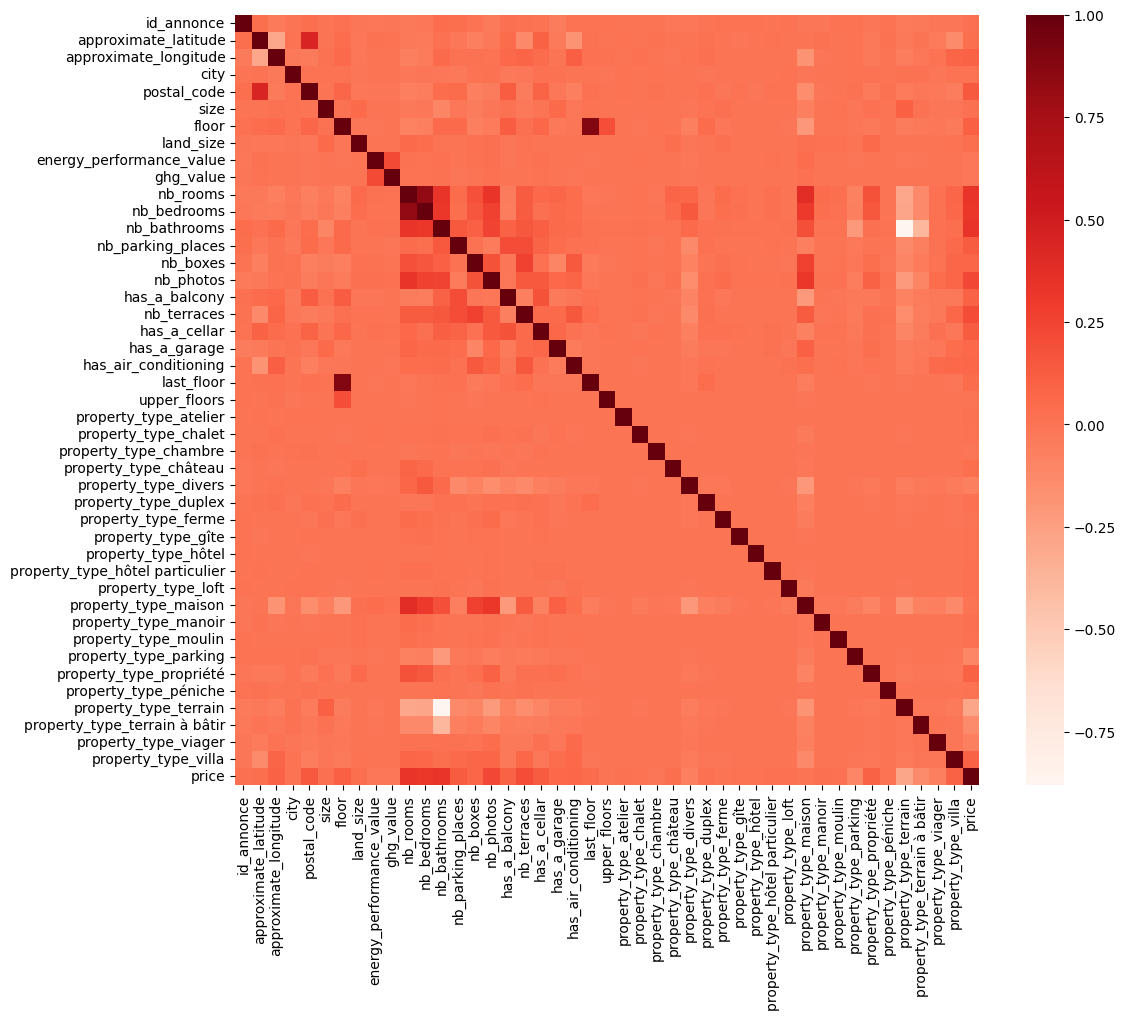

In [214]:
X_with_price = X.copy()
X_with_price["price"] = np.log1p(y["price"])

plt.figure(figsize=(12,10))
cor = X_with_price.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

#### On regarde aussi le score de Mutual Information

In [215]:
# from sklearn.feature_selection import mutual_info_regression

# discrete_features = X_with_price.dtypes == int
# mi_scores = mutual_info_regression(X_with_price, y, discrete_features=discrete_features)
# mi_scores = pd.DataFrame(mi_scores, index=X_with_price.columns, columns = ["MI Scores par rapport au prix"])
# mi_scores = mi_scores.sort_values(by="MI Scores par rapport au prix", ascending=False) # on tri les colonnes par MI score décroissant

# mi_scores.head(5)

> On remarque sur la matrice de corrélation, la forte corrélation entre le prix et nb_terraces, has_a_cellar, nb_photos, nb_rooms, nb_bedrooms, nb_bathrooms, postal_code. On refait une matrice de corrélation juste avec ses variables :

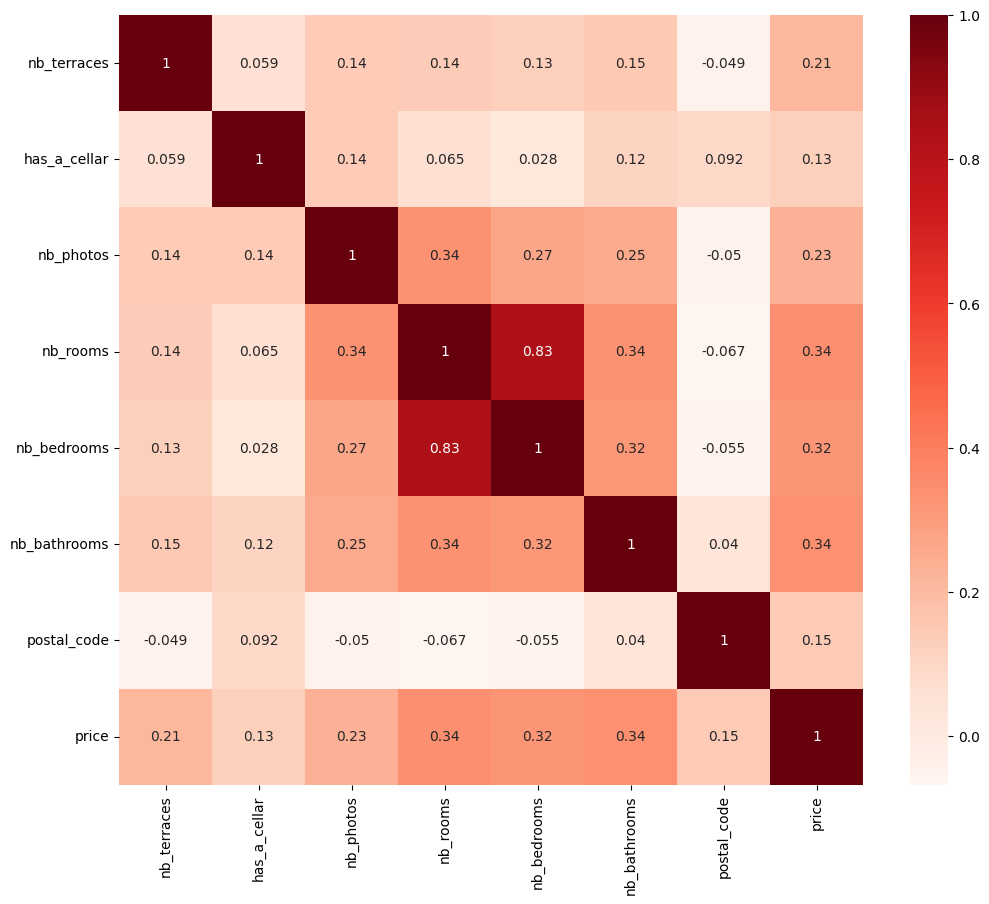

In [216]:
X_correlation = X_with_price[["nb_terraces", "has_a_cellar","nb_photos","nb_rooms","nb_bedrooms","nb_bathrooms","postal_code","price"]]

plt.figure(figsize=(12,10))
cor = X_correlation.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

> On essaie alors de créer d'autres variables à partir de celles-ci

In [217]:
price = X_correlation["price"]
X_correlation = X_correlation.drop(columns = ["price"],axis=1)
X_correlation["Sum_bedrooms_rooms"] = X_correlation["nb_rooms"]+X_correlation["nb_bedrooms"]
X_correlation["Sum_bathrooms_rooms"] = X_correlation["nb_rooms"]+X_correlation["nb_bathrooms"]
X_correlation["Diff_bedrooms_bathrooms"] = X_correlation["nb_bathrooms"]-X_correlation["nb_bedrooms"]
X_correlation["Ratio_size_rooms"] = X["size"]/X_correlation["nb_rooms"]

# Calcul des valeurs des départements plutôt que des codes postaux (en séparant les départements à 4 chiffres des départements à 5 chiffres)
X_correlation["departement"]=X_correlation["postal_code"]
X_correlation["departement"][X_correlation["departement"] < 10000]=X_correlation["departement"].astype(str).str[:1].astype(int)
X_correlation["departement"][X_correlation["departement"] >= 10000]=X_correlation["departement"].astype(str).str[:2].astype(int)

# Rajout du prix pour l'étude de corrélation
X_correlation["price"] = np.log1p(y["price"])

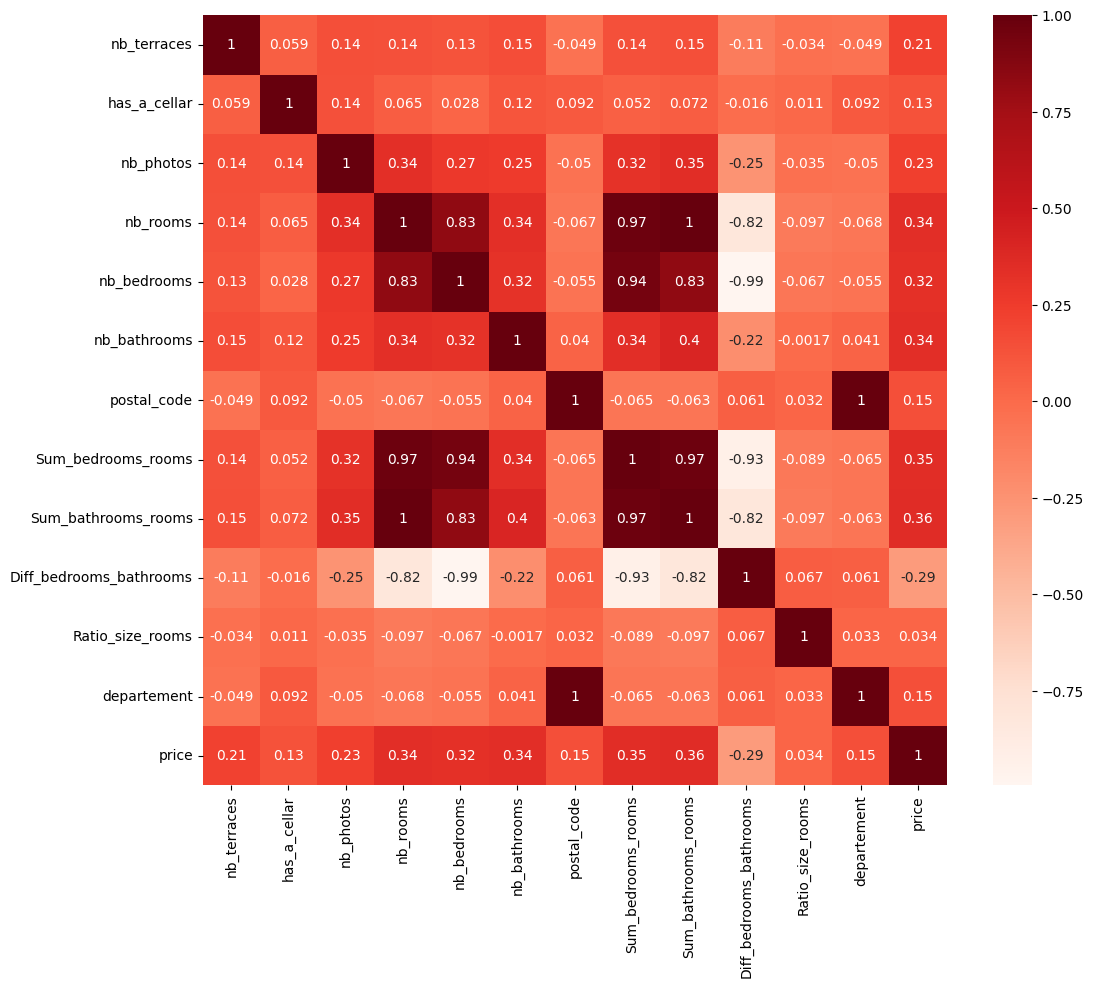

In [218]:
plt.figure(figsize=(12,10))
cor = X_correlation.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

> Dans les tentatives de rajout, les colonnes qui semblent intéressantes sont : Sum_bedrooms_rooms, Sum_bathrooms_rooms, Diff_bedrooms_bathrooms et departement. On les rajoute alors à X et on recalcule une heatmap :

In [219]:
X["Sum_bedrooms_rooms"] = X_correlation["Sum_bedrooms_rooms"]
X["Sum_bathrooms_rooms"] = X_correlation["Sum_bathrooms_rooms"]
X["Diff_bedrooms_bathrooms"] = X_correlation["Diff_bedrooms_bathrooms"]
X["departement"] = X_correlation["departement"]

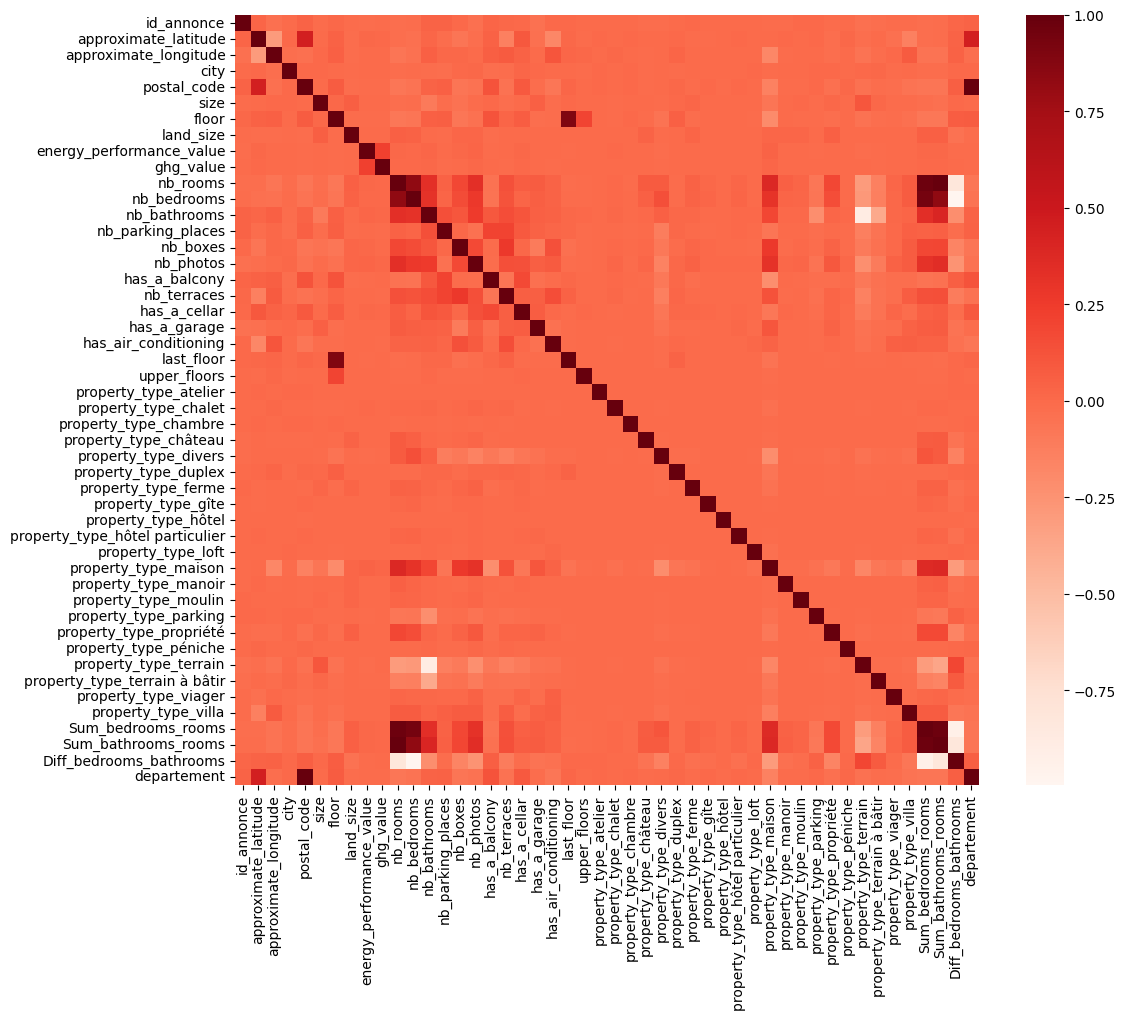

In [220]:
plt.figure(figsize=(12,10))
cor = X.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

> On vérifie le taux de données manquantes dans les colonnes nouvellement créées

In [221]:
colomnes = X.columns[X.isnull().any()]
nb_lignes = X.shape[0]
ratio_val_manquantes = {}


for col in colomnes:
    ratio_val_manquantes[col] = X[col].isnull().sum()/nb_lignes

ratio_val_manquantes = pd.DataFrame(ratio_val_manquantes.items(),columns = ["Nom Colonne","Ratio de valeurs manquantes"])
ratio_val_manquantes.sort_values(by = "Ratio de valeurs manquantes",ascending = False)

,Nom Colonne,Ratio de valeurs manquantes


## Ajout du score des images (obtenus par DL avec RoomNet)

> merge des deux tables pour rajouter le score sur X

In [222]:
images_train = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/traitement_photos/donnees_finales_images_train.csv")
images_train_final = images_train[["id_annonce","score"]] # On ne garde que les colonnes qui nous intéressent

In [223]:
X = X.merge(images_train_final, how='left', left_on='id_annonce', right_on='id_annonce')

> Et pour finir, on drop la colonne correspondant aux ids des annonces

In [224]:
X = X.drop(columns = ["id_annonce"],axis=1)

# Clusters

### Cluster des prix

> On calcule des clusters pour les prix afin de me visualiser leur répartition. Cependant, il ne faut pas utiliser ce Cluster comme feature, car il a directement été créé à partir de la target qu'est le prix.

In [225]:
# création d'un mini dataset avec les coordonnées et le prix pour pouvoir faire un clustering
X_cluster_prix = X[["approximate_latitude", "approximate_longitude"]]
X_cluster_prix["price"]=y[["price"]]
# print(X_cluster_prix.head()) 

kmeans = KMeans(n_clusters=6)
X_cluster_prix["Cluster"] = kmeans.fit_predict(X_cluster_prix)
X_cluster_prix["Cluster"] = X_cluster_prix["Cluster"].astype("category")

X_cluster_prix.head()

,approximate_latitude,approximate_longitude,price,Cluster
0,43.643880,7.117183,355000.0,0
1,45.695757,4.895610,190000.0,3
2,47.966791,-1.220451,39000.0,3
3,47.289292,-1.878805,299000.0,0
4,45.718992,4.844234,478000.0,4


#### Affichage graphique du clustering

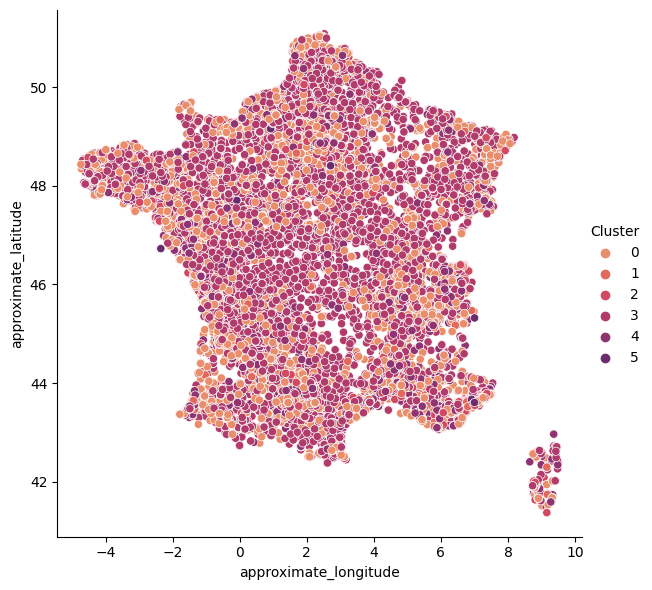

In [226]:
sns.relplot(x="approximate_longitude", y="approximate_latitude", hue = "Cluster", data=X_cluster_prix, height=6, palette = sns.color_palette("flare",n_colors = 6))

#### Création d'un clustering géographique avec la taille des biens

In [227]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for x in X.columns:
    if X[x].dtype != 'object':
        X[x] = scaler.fit_transform(X[x].values.reshape(-1,1))

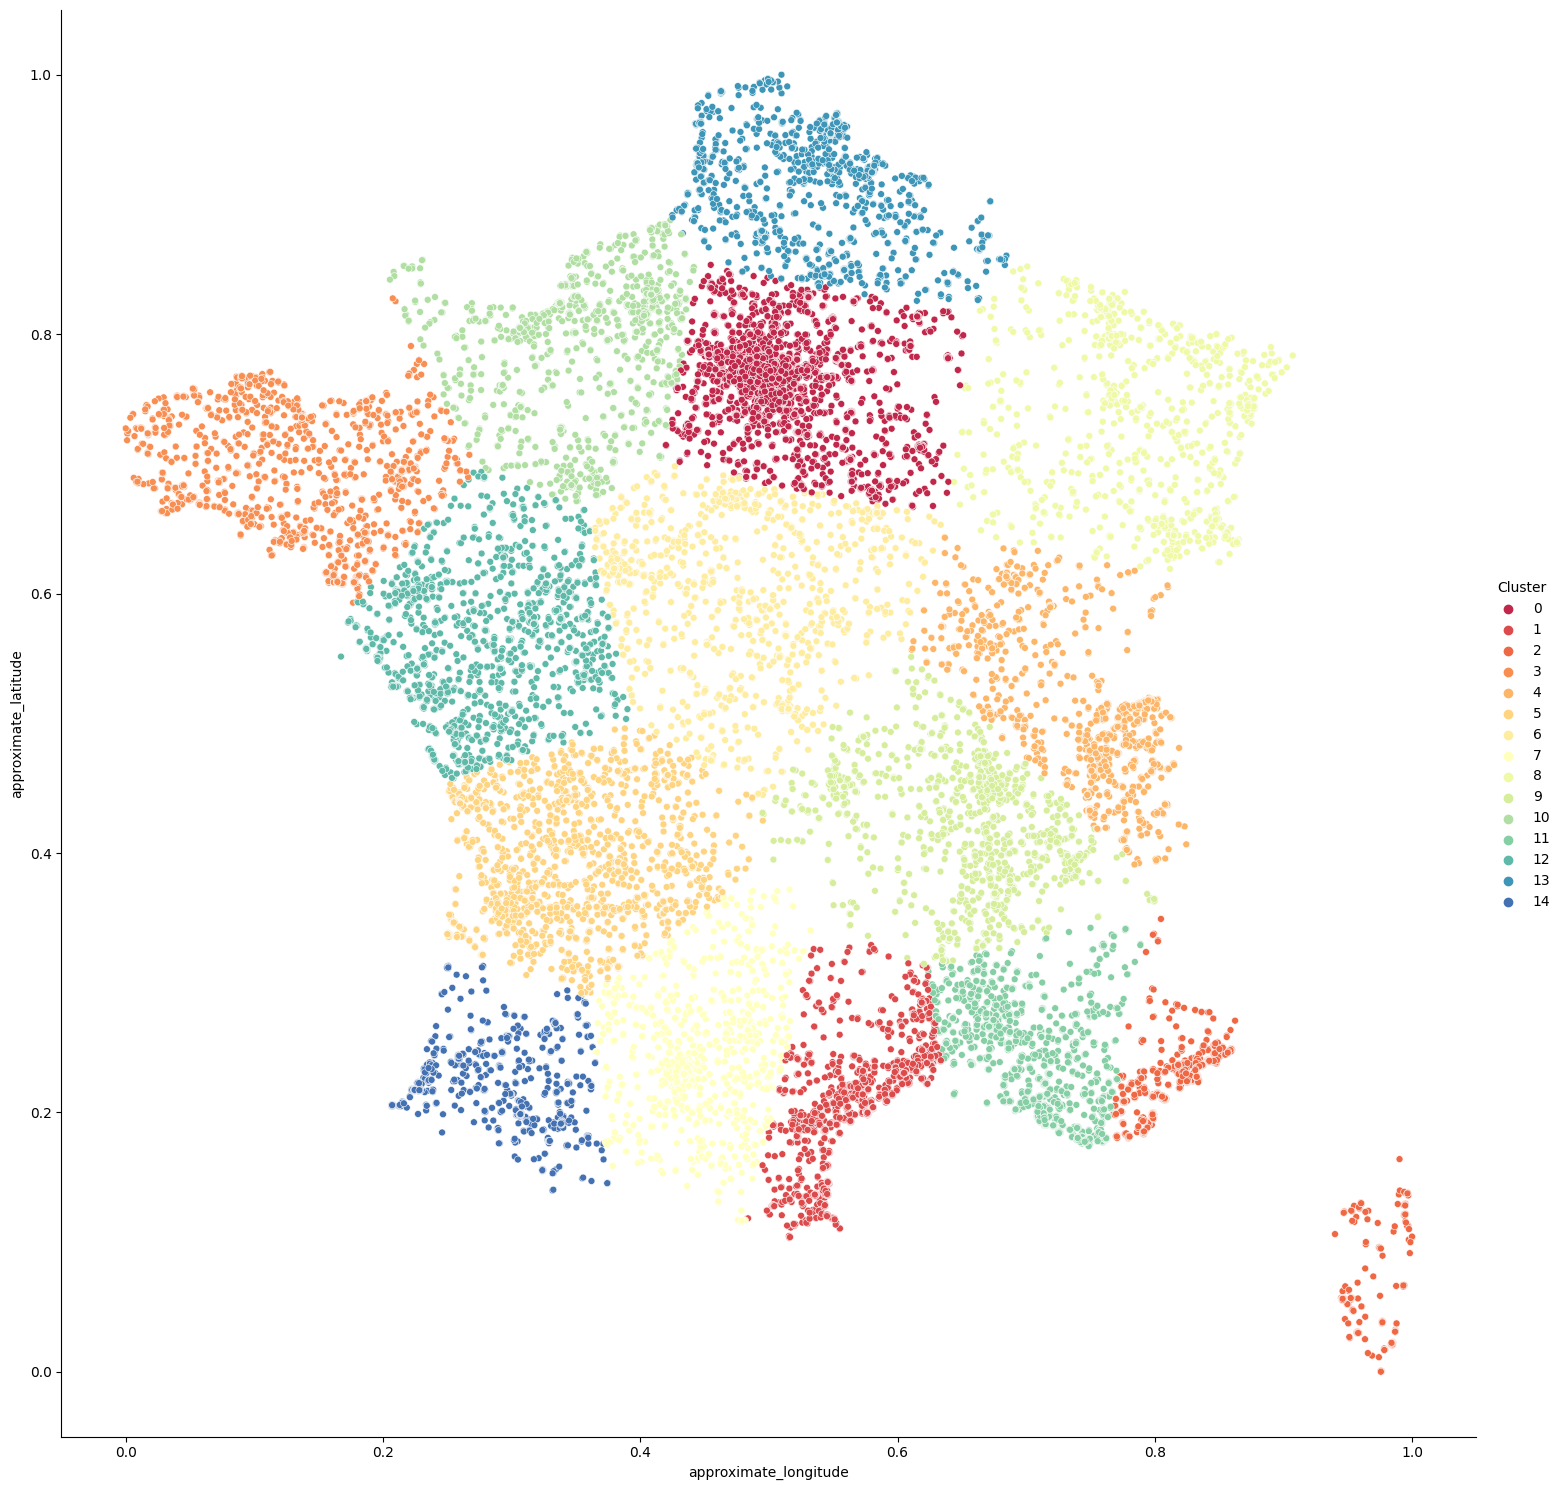

In [228]:
# création d'un mini dataset avec les coordonnées et le prix pour pouvoir faire un clustering
X_cluster_size = X[["approximate_longitude","approximate_latitude","Diff_bedrooms_bathrooms"]]
# print(X_cluster_prix.head())

N=15
kmeans = KMeans(n_clusters=N)
X_cluster_size["Cluster"] = kmeans.fit_predict(X_cluster_size)
X_cluster_size["Cluster"] = X_cluster_size["Cluster"].astype("category")
# print(X_cluster_size.head(10))

sns.relplot(x="approximate_longitude", y="approximate_latitude", hue = "Cluster", s=25,data=X_cluster_size, height=N, palette = sns.color_palette("Spectral",n_colors = N))

In [229]:
X["Cluster"]=X_cluster_size["Cluster"]

## Création d'un modèle de XGBoost

In [230]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for x in X.columns:
    if X[x].dtype != 'object':
        X[x] = scaler.fit_transform(X[x].values.reshape(-1,1))

y_log = np.log1p(y)
y_log = y_log.reset_index(drop=True)

In [63]:
train_X, test_X, train_y, test_y = train_test_split(X, y_log, test_size=0.2,random_state=1)

my_kfold = KFold(n_splits = 5,shuffle = True)
features_improv = {"n_estimators" :[x for x in range(100,800,100)],"learning_rate": [learning_r/20 for learning_r in range(1,4)]}

xgbc = GridSearchCV(xgb.XGBRegressor(),param_grid=features_improv,cv=my_kfold,n_jobs=-1)
xgbc.fit(train_X,train_y)
print(xgbc.best_params_)

prediction = xgbc.predict(test_X)

{'learning_rate': 0.1, 'n_estimators': 700}


In [64]:
# Pour au dessus : best params : {'learning_rate': 0.15, 'n_estimators': 700}

mean_absolute_percentage_error(np.expm1(test_y), np.expm1(prediction))*100

27.862735339125578

#### Etude des features importances à partir du modèle 

In [231]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2,random_state=1)

train_y = np.log1p(train_y)

xgb_imp = xgb.XGBRegressor(n_estimators=700,learning_rate=0.15,n_jobs=-1)
xgb_imp.fit(train_X,train_y)
prediction_y2 = xgb_imp.predict(test_X)
print(mean_absolute_percentage_error(test_y, np.expm1(prediction_y2))*100)


28.003510113588863


les 10 variables les plus importantes sont : ['size', 'property_type_maison', 'floor', 'nb_terraces', 'property_type_parking', 'nb_bedrooms', 'nb_rooms', 'property_type_viager', 'Sum_bedrooms_rooms', 'Cluster']
les 10 variables les moins importantes sont : ['departement', 'last_floor', 'nb_bathrooms', 'upper_floors', 'property_type_gîte', 'property_type_moulin', 'property_type_hôtel', 'property_type_atelier', 'property_type_péniche', 'property_type_hôtel particulier']


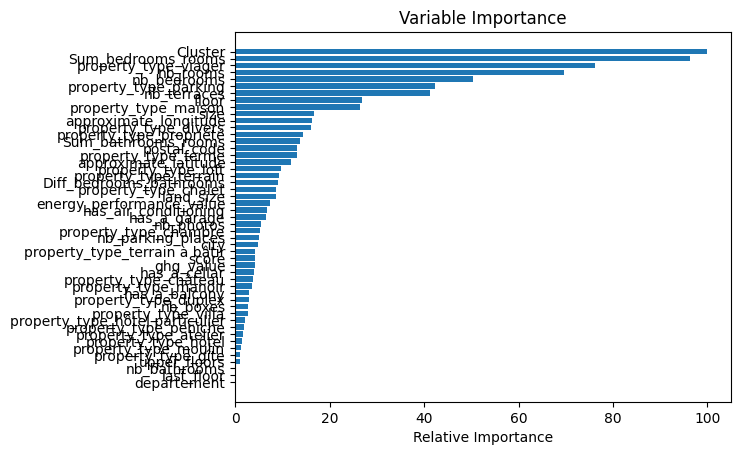

In [232]:
importance = xgb_imp.feature_importances_

f_importance = 100.0 * (importance / importance.max())
sorted_idx = np.argsort(f_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
imp_col = [X.columns[u] for u in sorted_idx]
print(f"les 10 variables les plus importantes sont : {imp_col[-10:]}")
print(f"les 10 variables les moins importantes sont : {imp_col[0:10]}")


plt.barh(pos, f_importance[sorted_idx], align='center')
plt.yticks(pos, imp_col)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()